# COMP47670 Assignment 2

### Task 2. Review Sentiment Classification
### Task 3. Review Helpfulness Classification

### Comp Number : 21202384

In [1]:
# Import needed libraries 
import os
import json
import re # Regular expression library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import cross_val_predict,train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_recall_curve,recall_score,precision_score,make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import nltk

In [2]:
# Load Data From disk
path_to_disk=r'C:\Users\DELL\Documents\\'
data_dict=json.load(fp=open(path_to_disk+'Product_Reviews\Reviews_Data.json','r'))
data_dict.keys()

dict_keys(['Titles', 'Star_Ratings', 'Reviews Help', 'Reviews'])

The Saved Json File will be converted to a Pandas DataFrame iwth the Dictionary Keys as Columns and Lists as entries.

In [3]:
data=pd.DataFrame(data_dict)
print('No of Reviews Entry: {}'.format(len(data)))
data.head(5)

No of Reviews Entry: 9244


,Titles,Star_Ratings,Reviews Help,Reviews
0,This filter works PERFECT!,5-star,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven..."
1,This stuff is great for muffins,4-star,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...
2,Curiously awful,1-star,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...
3,Rancid!,1-star,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p..."
4,They taste like boogers,1-star,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega..."


The DataFrame is shown in the cell above, each entry /Index is a single Review . There are 9244 Review entrys in the Set.

In [4]:
# Check for any missing dta entry
data.isnull().sum()

Titles          0
Star_Ratings    0
Reviews Help    0
Reviews         0
dtype: int64

The Cell above shows that there are no missing entry in the set.

In [5]:
# Checking for data types 
data.dtypes

Titles          object
Star_Ratings    object
Reviews Help    object
Reviews         object
dtype: object

We check The Data for duplicated entries.If any, it will be assumed that Infomation about a single product appears Multiple times in the dataset. 

In [6]:
# Check for duplicated Entries
print('Number of Duplicated Entries in Dataset: {}'.format(data.duplicated().sum()))
# A View of the duplicated entries in sorted order
data[data.duplicated()].sort_values(by='Titles')

Number of Duplicated Entries in Dataset: 2167


,Titles,Star_Ratings,Reviews Help,Reviews
8901,""" A MIRACLE SUPPLEMENT!!""",5-star,39 out of 47 users found this review helpful,I'm a 32 year old man. Construction Electricia...
3027,""" A MIRACLE SUPPLEMENT!!""",5-star,39 out of 47 users found this review helpful,I'm a 32 year old man. Construction Electricia...
5665,""" A MIRACLE SUPPLEMENT!!""",5-star,39 out of 47 users found this review helpful,I'm a 32 year old man. Construction Electricia...
8170,""" A MIRACLE SUPPLEMENT!!""",5-star,39 out of 47 users found this review helpful,I'm a 32 year old man. Construction Electricia...
5654,""" A MIRACLE SUPPLEMENT!!""",5-star,39 out of 47 users found this review helpful,I'm a 32 year old man. Construction Electricia...
...,...,...,...,...
1127,you won't miss the salt,4-star,16 out of 16 users found this review helpful,I ordered these chips by accident. I meant to ...
5164,you won't miss the salt,4-star,16 out of 16 users found this review helpful,I ordered these chips by accident. I meant to ...
4162,you won't miss the salt,4-star,16 out of 16 users found this review helpful,I ordered these chips by accident. I meant to ...
7884,you won't miss the salt,4-star,16 out of 16 users found this review helpful,I ordered these chips by accident. I meant to ...


The cell shows the duplicated entries in the dataset. Duplicated entries are not desirable because they contain redundant information and a repetition of entries. we will drop these entries.

In [7]:
# Dropping duplicated columns
data.drop_duplicates(inplace=True)
data.shape

(7077, 4)

There are now 7077 Remaining entries in the dataset after dropping the Duplicated entries.

we check if the title coulmn has any duplicated entry. 

In [8]:
# Check for duplicated title entry
print('Number of Duplicated Titles in Dataset: {}'.format(data.Titles.duplicated().sum()))
# SElecting duplicated entries to view
data[data.Titles.duplicated()].sort_values(by='Titles')

Number of Duplicated Titles in Dataset: 324


,Titles,Star_Ratings,Reviews Help,Reviews
5929,#1 superfood,5-star,15 out of 16 users found this review helpful,Nutritional benefits of Chia seeds are amazing...
5224,A delicious treat,5-star,31 out of 37 users found this review helpful,"Well, since some other user decided they'd pas..."
6041,A delicious treat,5-star,7 out of 13 users found this review helpful,"Well, since some other user decided they'd pas..."
9101,A delicious treat,5-star,10 out of 14 users found this review helpful,"Well, since some other user decided they'd pas..."
1783,A great product!,5-star,14 out of 16 users found this review helpful,This pinole is a great product! It tastes grea...
...,...,...,...,...
5594,not worth the money,1-star,26 out of 30 users found this review helpful,"This is a nice idea, but you can only fit half..."
8659,not worth the money,1-star,12 out of 13 users found this review helpful,"I have been on low carb diet for years, and i ..."
4868,overpriced,2-star,12 out of 15 users found this review helpful,"Product is ok, but I consider it very expensiv..."
8503,rip off,1-star,5 out of 16 users found this review helpful,As much as this sauce is the most definitive a...


There are still 324 Duplicated Titles in the Dataset after dropping the general duplicated entries. A closer look shows that the entries differ by different degrees, some differ slightly while some differ Very well. we will retain these entries so that we will not lose important information That may be lost if they are dropped from the dataset.

In [9]:
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews
0,This filter works PERFECT!,5-star,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven..."
1,This stuff is great for muffins,4-star,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...
2,Curiously awful,1-star,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...
3,Rancid!,1-star,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p..."
4,They taste like boogers,1-star,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega..."


<AxesSubplot:title={'center':'Stars Rating Plot'}, xlabel='Star_Ratings', ylabel='Count'>

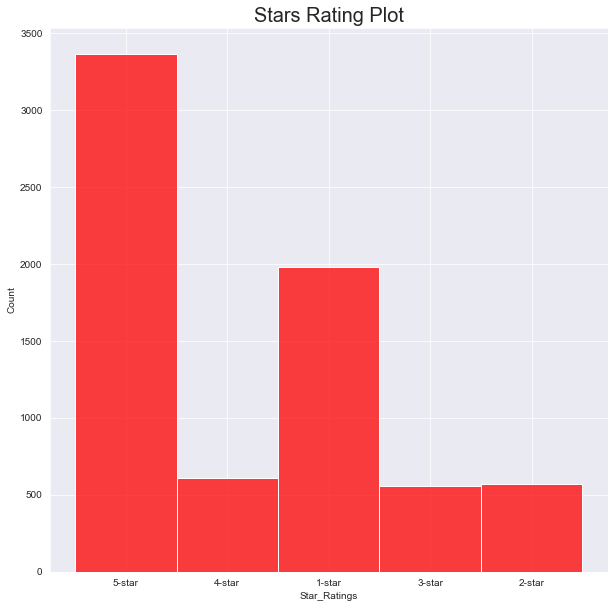

In [10]:
# Plot of Star Ratings
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plt.title('Stars Rating Plot',size=20)
sns.histplot(data.Star_Ratings,color='r')

The Plot above shows the number of Star Ratings in the dataset.5 Star Ratings have the Highest entries. 

We will concatenate(Add) the Titles Columns to Reviews Text for Purpose of Analysis.

In [11]:
# Concatenate Body Titles and Text
data['Titles_Reviews']=data.Titles+' '+data.Reviews
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,5-star,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,4-star,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,1-star,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,1-star,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,1-star,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


For the Purposes of Classification, we will clean the Titles_Reviews Column to retain useful and important texts only. 

In [12]:
data_text=data.Titles_Reviews.values
data_text[:5]

array(['This filter works PERFECT! Seriously, I love my Keurig. I love the convenience and the coffees. But what I don\'t love is buying $50 dollars worth of coffee every month. I tried the filter that Keurig gave me with my Platinum B70 model and it made my awesome Guatemalan Coffee I used to brew the "old fashion way" into a watered down mess no matter how fine I ground the bean or how much I reduced the cup size. I was skeptical about buying another kcup filter when I saw this offered on Superstore, but the video add on the ekobrew website had me sold. I bought the ekobrew Cup before it was available for sale with high hopes, and it has totally lived up to my expectations! My freshly ground coffee tastes better than any Kcup I have ever had! I forgot how good some of the beans I bought were. No Joke. If you are like me and have a few roasts of beans you just love and don\'t feel like breaking the bank trying every kcup under the sun to find blends that please you then get it. You wo

The cell above shows The first three Review Texts in the DataSet. It contains texts that needs to be cleaned up, we will apply some string preprocessing steps with the help of the Regular Expression and NLTK Libraries to clean up the texts.

In [13]:
# Converting The text to lower case
data_text=[text.lower() for text in data_text]
data_text[:3]

['this filter works perfect! seriously, i love my keurig. i love the convenience and the coffees. but what i don\'t love is buying $50 dollars worth of coffee every month. i tried the filter that keurig gave me with my platinum b70 model and it made my awesome guatemalan coffee i used to brew the "old fashion way" into a watered down mess no matter how fine i ground the bean or how much i reduced the cup size. i was skeptical about buying another kcup filter when i saw this offered on superstore, but the video add on the ekobrew website had me sold. i bought the ekobrew cup before it was available for sale with high hopes, and it has totally lived up to my expectations! my freshly ground coffee tastes better than any kcup i have ever had! i forgot how good some of the beans i bought were. no joke. if you are like me and have a few roasts of beans you just love and don\'t feel like breaking the bank trying every kcup under the sun to find blends that please you then get it. you won\'t b

There are no more upper case alphabets in the text.

In [14]:
# Split the Text using any character other than an alphabet.
data_text=[re.findall(r'\s+(\w+)',text) for text in data_text]
data_text[:2]

[['filter',
  'works',
  'perfect',
  'seriously',
  'i',
  'love',
  'my',
  'keurig',
  'i',
  'love',
  'the',
  'convenience',
  'and',
  'the',
  'coffees',
  'but',
  'what',
  'i',
  'don',
  'love',
  'is',
  'buying',
  'dollars',
  'worth',
  'of',
  'coffee',
  'every',
  'month',
  'i',
  'tried',
  'the',
  'filter',
  'that',
  'keurig',
  'gave',
  'me',
  'with',
  'my',
  'platinum',
  'b70',
  'model',
  'and',
  'it',
  'made',
  'my',
  'awesome',
  'guatemalan',
  'coffee',
  'i',
  'used',
  'to',
  'brew',
  'the',
  'fashion',
  'way',
  'into',
  'a',
  'watered',
  'down',
  'mess',
  'no',
  'matter',
  'how',
  'fine',
  'i',
  'ground',
  'the',
  'bean',
  'or',
  'how',
  'much',
  'i',
  'reduced',
  'the',
  'cup',
  'size',
  'i',
  'was',
  'skeptical',
  'about',
  'buying',
  'another',
  'kcup',
  'filter',
  'when',
  'i',
  'saw',
  'this',
  'offered',
  'on',
  'superstore',
  'but',
  'the',
  'video',
  'add',
  'on',
  'the',
  'ekobrew',
  

The regular expression r '\s+(\w+)' selects only the texts (\d+) that follows a whitespace (\s+) it doesnt include any other character as it strips them off the text and discard them,it doesnt include numbers/digits and returns a list of selected words.

Some entries can be considered to be uninformative to be used for sentiment analysis, entries such as Digits/Numbers (Which have been removed from the text using the Regular expresssion above), words with length less than Four and stopwords,These will be removed from the text.

In [15]:
# Function to Print the Total Number of words In the text
def Get_Count(text):
    Count=0;Unique_Count=[];
    for t in text:
        Count+=len(t);
        for x in t:
            Unique_Count.append(x)
    print('Number of Total words in Text {}'.format(Count))
    print('\nNumber of Unique Words in Text {}'.format(len(set(Unique_Count))))

In [16]:
# The Number of Words in Text
Get_Count(data_text)

Number of Total words in Text 1025603

Number of Unique Words in Text 25847


There are Over a Million Total words in the text and 25847 Unique Words. we will try to reduce the number of unique words in the text using various methods.

In [17]:
# Function to drop words with (Length) less than a threshold
def Drop_Words(text,threshold=3):
    t=[[x for x in y if len(x)>threshold] for y in text]
    return t

In [18]:
# Drop Words with Length Less than 3
data_text=Drop_Words(data_text,threshold=3)
data_text[-3:]

[['need',
  'little',
  'math',
  'ensure',
  'superstore',
  'quantity',
  'good',
  'deal',
  'product',
  'gets',
  'stars',
  'this',
  'review',
  'more',
  'product',
  'amount',
  'same',
  'what',
  'typically',
  'found',
  'grocery',
  'stores',
  'uploaded',
  'image',
  'grocery',
  'store',
  'usually',
  'find',
  'that',
  'contains',
  'packets',
  'that',
  'makes',
  'quarts',
  'that',
  'what',
  'getting',
  'here',
  'getting',
  'four',
  'cans',
  'that',
  'each',
  'contain',
  'packets',
  'that',
  'make',
  'quarts',
  'packets',
  'store',
  'make',
  'quarts',
  'each',
  'superstore',
  'packets',
  'make',
  'only',
  'quart',
  'each',
  'take',
  'little',
  'math',
  'ensure',
  'getting',
  'decent',
  'value',
  'store',
  'about',
  'cents',
  'quart',
  'based',
  'dollar',
  'sale',
  'price'],
 ['resist',
  'these',
  'real',
  'flashback',
  'they',
  'taste',
  'just',
  'like',
  'remember',
  'downright',
  'addictive',
  'everyone',
  'wil

In [19]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 581888

Number of Unique Words in Text 24230


The Total Number of words in the text have been reduced by half,this implies that words with length less than 3 made up for almost have of the total words in the text.

Stopwords will b removed from text

In [20]:
# Loading Stopwords from the NLTK library
nltk.download('stopwords') # Downloads Stopwords corpus from NLTK
stopwords=nltk.corpus.stopwords.words('english') # Selects only english Stopwords
stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [21]:
# Removing stopwords From News Text
data_text=[[word for word in text if word not in stopwords] for text in data_text] # List Comprehension
data_text[-5:]

[['compostable',
  'bought',
  'bags',
  'trading',
  'gallon',
  'kitchen',
  'compost',
  'waste',
  'collector',
  'purchased',
  'superstore',
  'bags',
  'perfectly',
  'seem',
  'start',
  'degrading',
  'within',
  'days',
  'took',
  'compost',
  'every',
  'would',
  'fine',
  'empty',
  'compost',
  'bucket',
  'twice',
  'week',
  'lift',
  'take',
  'outside',
  'dripping',
  'take',
  'whole',
  'bucket',
  'scrub',
  'thoroughly',
  'afterwards',
  'odor',
  'previously',
  'used',
  'regular',
  'plastic',
  'shopping',
  'leakage',
  'almost',
  'never',
  'problem',
  'regular',
  'occurance',
  'liners',
  'like',
  'bags',
  'biodegradable',
  'rather',
  'purchasing',
  'probably',
  'back',
  'plastic',
  'bags',
  'supply',
  'runs',
  'find',
  'sturdier',
  'brand',
  'suggestions'],
 ['really',
  'great',
  'problems',
  'aspartame',
  'every',
  'sugarfree',
  'gums',
  'love',
  'chew',
  'steviadent',
  'really',
  'option',
  'unless',
  'want',
  'tictacs'

In [22]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 458661

Number of Unique Words in Text 24148


We will use a custom Downloaded Stopwords List to further remove stopwords from text

In [23]:
# Load  Custom Stopwords From Text
stop=[x.strip().decode() for x in open(r'C:\Users\DELL\Documents\Words\stop_words_english.txt','rb')]
stop[:5]

['able', 'about', 'above', 'abroad', 'according']

In [24]:
# Removing stopwords From News Text
data_text=[[word for word in text if word not in stop] for text in data_text] # List Comprehension
data_text[-5:]

[['compostable',
  'bought',
  'bags',
  'trading',
  'gallon',
  'kitchen',
  'compost',
  'waste',
  'collector',
  'purchased',
  'superstore',
  'bags',
  'perfectly',
  'start',
  'degrading',
  'days',
  'compost',
  'fine',
  'compost',
  'bucket',
  'week',
  'lift',
  'dripping',
  'bucket',
  'scrub',
  'odor',
  'regular',
  'plastic',
  'shopping',
  'leakage',
  'problem',
  'regular',
  'occurance',
  'liners',
  'like',
  'bags',
  'biodegradable',
  'purchasing',
  'plastic',
  'bags',
  'supply',
  'runs',
  'sturdier',
  'brand',
  'suggestions'],
 ['great',
  'problems',
  'aspartame',
  'sugarfree',
  'gums',
  'love',
  'chew',
  'steviadent',
  'option',
  'tictacs',
  'good',
  'expensive',
  'completely',
  'worth',
  'compromise',
  'health',
  'chewed',
  'lots',
  'started',
  'notice',
  'painful',
  'lump',
  'roof',
  'mouth',
  'reaction',
  'cancer',
  'dentists',
  'oral',
  'surgeon',
  'check',
  'confirmed',
  'aspartame',
  'upset',
  'stomach',
  '

In [25]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 359235

Number of Unique Words in Text 23670


Stemming is the process of producing root/base words of various words in a text. We will use the Porter Stemmer from the NLTK library to stem the various words in text

In [26]:
# Stemming the Words
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
data_text=[[stemmer.stem(word) for word in text] for text in data_text] # Stem the words in the text using list comprehension
data_text[-5: ]

[['compost',
  'bought',
  'bag',
  'trade',
  'gallon',
  'kitchen',
  'compost',
  'wast',
  'collector',
  'purchas',
  'superstor',
  'bag',
  'perfectli',
  'start',
  'degrad',
  'day',
  'compost',
  'fine',
  'compost',
  'bucket',
  'week',
  'lift',
  'drip',
  'bucket',
  'scrub',
  'odor',
  'regular',
  'plastic',
  'shop',
  'leakag',
  'problem',
  'regular',
  'occur',
  'liner',
  'like',
  'bag',
  'biodegrad',
  'purchas',
  'plastic',
  'bag',
  'suppli',
  'run',
  'sturdier',
  'brand',
  'suggest'],
 ['great',
  'problem',
  'aspartam',
  'sugarfre',
  'gum',
  'love',
  'chew',
  'steviad',
  'option',
  'tictac',
  'good',
  'expens',
  'complet',
  'worth',
  'compromis',
  'health',
  'chew',
  'lot',
  'start',
  'notic',
  'pain',
  'lump',
  'roof',
  'mouth',
  'reaction',
  'cancer',
  'dentist',
  'oral',
  'surgeon',
  'check',
  'confirm',
  'aspartam',
  'upset',
  'stomach',
  'point',
  'extrem',
  'bloat',
  'initi',
  'attribut',
  'aspartam',
  

In [27]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 359235

Number of Unique Words in Text 16028


Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word (nlp.stanford.edu). We will lemmatize the text using the default WordNet Lemmatizer in the NLTK library.

In [28]:
# Lemmatizing Text Data
nltk.download('wordnet') # Download Wordnet from NLTK library
lemma=nltk.stem.WordNetLemmatizer() # Initializing the WordNet Lemmatizer
data_text=[[lemma.lemmatize(word) for word in text] for text in data_text] # Lemmatize words in the text using list comprehension
data_text[-5: ]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['compost',
  'bought',
  'bag',
  'trade',
  'gallon',
  'kitchen',
  'compost',
  'wast',
  'collector',
  'purchas',
  'superstor',
  'bag',
  'perfectli',
  'start',
  'degrad',
  'day',
  'compost',
  'fine',
  'compost',
  'bucket',
  'week',
  'lift',
  'drip',
  'bucket',
  'scrub',
  'odor',
  'regular',
  'plastic',
  'shop',
  'leakag',
  'problem',
  'regular',
  'occur',
  'liner',
  'like',
  'bag',
  'biodegrad',
  'purchas',
  'plastic',
  'bag',
  'suppli',
  'run',
  'sturdier',
  'brand',
  'suggest'],
 ['great',
  'problem',
  'aspartam',
  'sugarfre',
  'gum',
  'love',
  'chew',
  'steviad',
  'option',
  'tictac',
  'good',
  'expens',
  'complet',
  'worth',
  'compromis',
  'health',
  'chew',
  'lot',
  'start',
  'notic',
  'pain',
  'lump',
  'roof',
  'mouth',
  'reaction',
  'cancer',
  'dentist',
  'oral',
  'surgeon',
  'check',
  'confirm',
  'aspartam',
  'upset',
  'stomach',
  'point',
  'extrem',
  'bloat',
  'initi',
  'attribut',
  'aspartam',
  

In [29]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 359235

Number of Unique Words in Text 16001


String Preprocessing steps done above will be repeated multiple times because after a string process a previous step doen earlier may become necessary. For Instance, after Lemmatization some words are stripped of letters at their ends these words end up as three(3) lettered words as seen in the cell above which are not needed in our text, we will remove these words.

In [30]:
# Function to drop words with Length less than a threshold
def Drop_Words(text,threshold=3):
    t=[[x for x in y if len(x)>threshold] for y in text]
    return t

In [31]:
# Dropping words less than with length less than 3
data_text=Drop_Words(data_text,threshold=3)
data_text[-3:]

[['math',
  'ensur',
  'superstor',
  'quantiti',
  'good',
  'deal',
  'product',
  'star',
  'review',
  'product',
  'typic',
  'groceri',
  'store',
  'upload',
  'imag',
  'groceri',
  'store',
  'packet',
  'quart',
  'packet',
  'quart',
  'packet',
  'store',
  'quart',
  'superstor',
  'packet',
  'quart',
  'math',
  'ensur',
  'decent',
  'store',
  'cent',
  'quart',
  'base',
  'dollar',
  'sale',
  'price'],
 ['resist',
  'real',
  'flashback',
  'tast',
  'like',
  'rememb',
  'downright',
  'addict',
  'mooch',
  'plenti',
  'complaint',
  'sturdi',
  'toothpick',
  'flavor'],
 ['coca',
  'pure',
  'leaf',
  'coca',
  'strong',
  'flavor',
  'dark',
  'brew',
  'fresh',
  'aroma']]

In [32]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 346021

Number of Unique Words in Text 15592


The cell above that there are 262033 Unique words in the text. The text is clean enough to be used for modelling and predictions, but it has a large feature space. If countvectorizer/Bag-of-words method is used to convert the text to numerical, we will have a Sparse Matrix with 262033 Columns, this is very large and pose problems for most shallow machine learning algorithms, it will also require more computational resources to carry out some Machine Learning Methods. We will employ other methods to further reduce our feature space.

In [33]:
# A Look at Four Lettered Words in the text
four_words=[text for y in data_text for text in y if len(text)==4]
four_words[:5]

['work', 'love', 'love', 'love', 'brew']

In [34]:
# Length of Four letter words
len(four_words)

103089

In [35]:
# Converting to NLTK corpus Text
four_words=nltk.Text(four_words)
four_words

<Text: work love love love brew mess fine bean...>

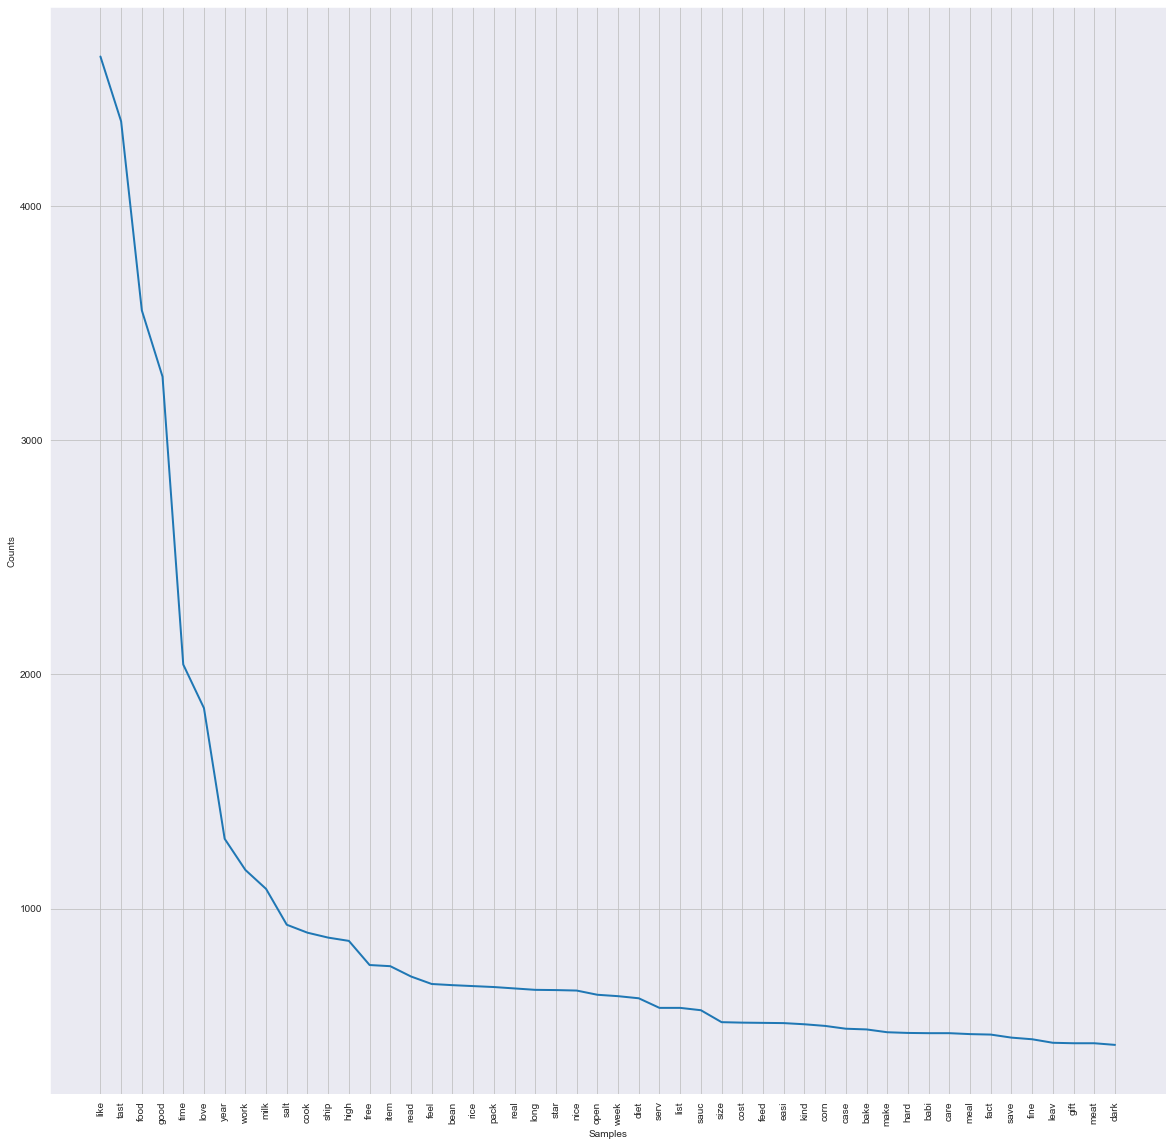

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [36]:
four_words=nltk.FreqDist(four_words)
plt.figure(figsize=(20,20))
four_words.plot(50)

The plot above shows the top 50 Four Lettered words in the text. Most of the four letter words are uninformative with the exception of just few of them that likely shows sentiments, words such as 'love','like','good' , the four lettered words will be dropped with the exception of these words.

In [37]:
data_text=[[word for word in text if len(word)>4 and word not in ['like','love','good','nice','acid','hard']] for text in data_text]
data_text[-5:]

[['compost',
  'bought',
  'trade',
  'gallon',
  'kitchen',
  'compost',
  'collector',
  'purchas',
  'superstor',
  'perfectli',
  'start',
  'degrad',
  'compost',
  'compost',
  'bucket',
  'bucket',
  'scrub',
  'regular',
  'plastic',
  'leakag',
  'problem',
  'regular',
  'occur',
  'liner',
  'biodegrad',
  'purchas',
  'plastic',
  'suppli',
  'sturdier',
  'brand',
  'suggest'],
 ['great',
  'problem',
  'aspartam',
  'sugarfre',
  'steviad',
  'option',
  'tictac',
  'expens',
  'complet',
  'worth',
  'compromis',
  'health',
  'start',
  'notic',
  'mouth',
  'reaction',
  'cancer',
  'dentist',
  'surgeon',
  'check',
  'confirm',
  'aspartam',
  'upset',
  'stomach',
  'point',
  'extrem',
  'bloat',
  'initi',
  'attribut',
  'aspartam',
  'start',
  'notic',
  'bigger',
  'start',
  'aspartam',
  'culprit',
  'order',
  'steviad',
  'pitch',
  'contain',
  'asapartam',
  'mouth',
  'disappear',
  'ingest',
  'aspartam',
  'stomach',
  'bloat',
  'complet',
  'worth',

In [38]:
# A Count of the Remaining words in text
Get_Count(data_text)

Number of Total words in Text 242932

Number of Unique Words in Text 13223


Multiple steps and techniques have been undertaken to clean the text. The number of unique Text (Feature) space has been reduced from 25000+ to 13223 with the removal of words considered to be uninformative. The total Number of Words reduced from 1000000+ to 242932.  

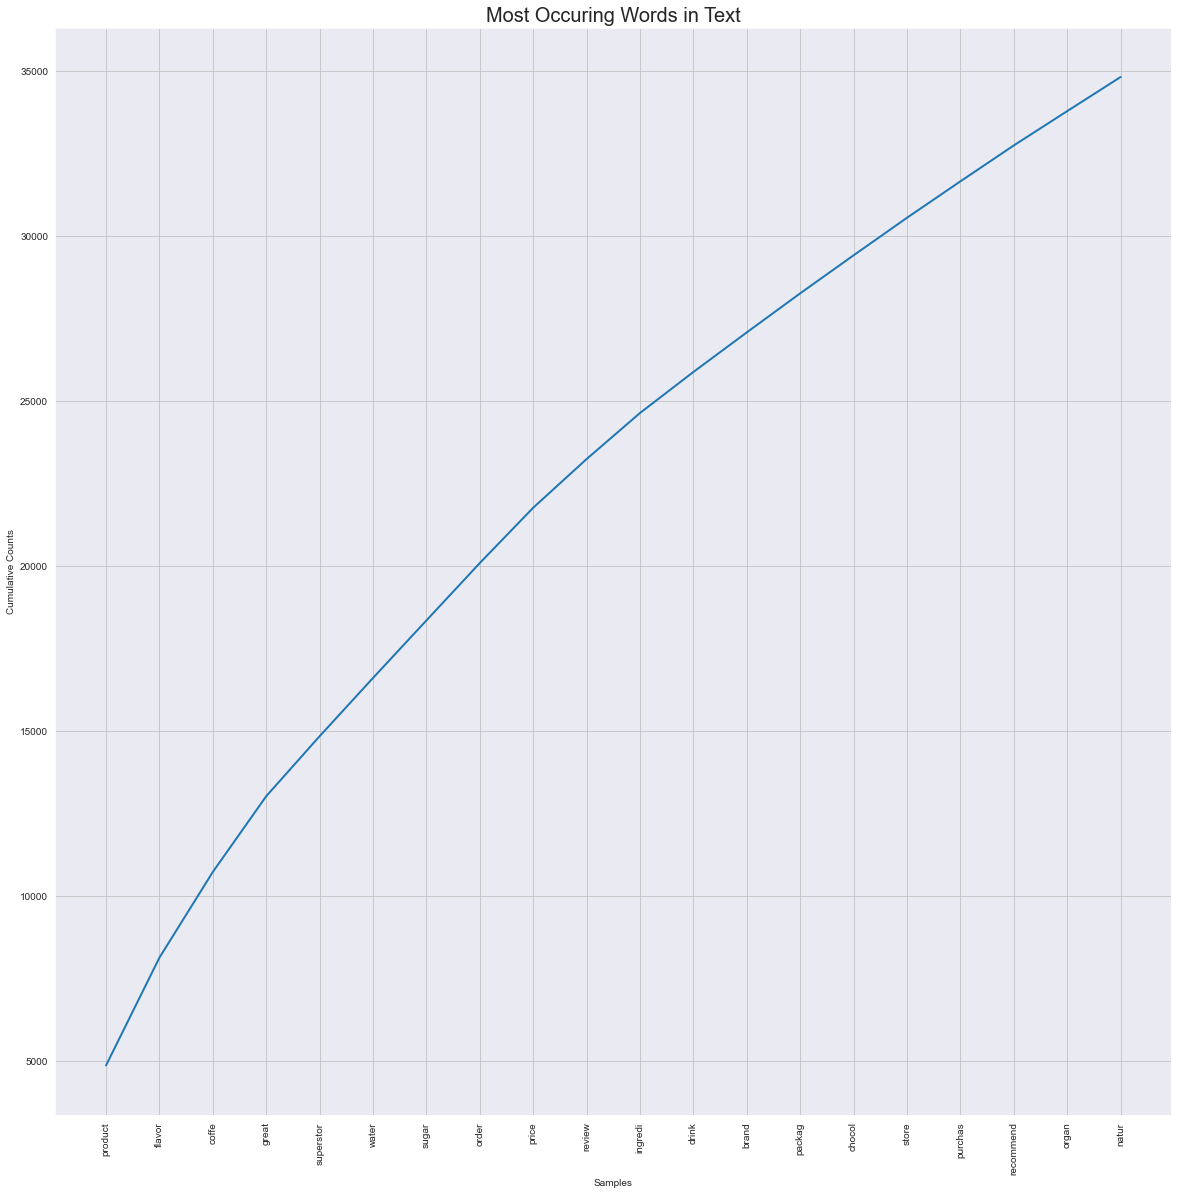

<AxesSubplot:title={'center':'Most Occuring Words in Text'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [39]:
# A look at the most Occuring Words in the Text
data_temp=[word for text in data_text for word in text]
data_temp=nltk.Text(data_temp)
data_temp=nltk.FreqDist(data_temp)
# Plot the freq Dist
plt.figure(figsize=(20,20))
plt.title('Most Occuring Words in Text',size=20)
data_temp.plot(20,cumulative=True)

The Plot above shows the most occuring words in the text. words such as coffe,sugar,water,product which will likely not help in senetiment analysis occur very much in the text.

#### Data Vectorization 

We will use the Bag of Words Method to convert our text to Numerical representation suitable for Machine Learning Modelling. The Bag of words handles each distinct word appearing in the text as a feature on its own without considerong its contextual or semantic meaning. This means that Bag of Words handles words at the word level,therefore we dont need the words to be accurately rather we want similar words to have same spelling (whether Corrrect or wrong) int the text, Stemming and Lemmatizing helped us achieved this by stipped words to their roots.

The Count Vectorizer in sklearn Library offers Methods to convert words into their vector representation. To avoid having the problem of overfitting of models we will use only the top 10000 occuring words in the text because the least occuring words are more specific to particular documents.

In [40]:
## Using CountVectorier To convert Words to Vectors
count_vec=CountVectorizer(max_features=1000) # Selects the first Top 10000 words to create as features
tfid=TfidfTransformer()
data_mat=count_vec.fit_transform([' '.join(x) for x in data_text]).toarray() # toarray returns the sparse matrix to Numpy arrays
data_mat=tfid.fit_transform(data_mat).toarray()
data_mat.shape

(7077, 1000)

Our text have been converted into a matrix of 10000 Features this is a sparse matirx because for most parts it contains zeros.There are 7077 entires in the Matrix.

In [41]:
data_mat[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## REVIEW SENTIMENT CLASSIFICATION

### Target Variable Preprocessing

Our Target Variable is the Stars ratings. we seek to classify each document as either having a positive or Negative Review. We will assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews are “positive” 

In [42]:
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,5-star,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,4-star,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,1-star,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,1-star,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,1-star,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [43]:
# Extract only the Numbers/Digits from the Stars Rating Coulmns
data.Star_Ratings=[int(re.findall(r'\d+',rating)[0]) for rating in data.Star_Ratings] # Extracts The Ratings and convert to integer
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,5,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,4,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,1,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,1,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,1,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [44]:
# Categorizing the Star_Ratings Columns
data.Star_Ratings=np.where(data.Star_Ratings<=3,'Negative','Positive')
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,Positive,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,Positive,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,Negative,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,Negative,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,Negative,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [45]:
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,Positive,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,Positive,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,Negative,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,Negative,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,Negative,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


<AxesSubplot:title={'center':'Plot of Star Ratings Category'}, xlabel='Star_Ratings', ylabel='Percent'>

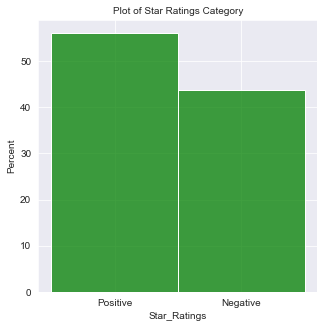

In [46]:
# A plot of positive and Negative stars ratings
plt.figure(figsize=(5,5))
plt.title('Plot of Star Ratings Category',size=10)
sns.histplot(data.Star_Ratings,color='g',stat='percent')


The Stars Rating have been categorized as either positive or Negative as sen in the cell Above.

For the purposes of model building we need to convert the stars ratings categories into digits/Numbers. will we assign the Class Negative as 0 nd the positive Class as 1.

In [47]:
target_dict={'Negative':0,'Positive':1} # Target Dictionary
target_dict

{'Negative': 0, 'Positive': 1}

In [48]:
data.Star_Ratings=data.Star_Ratings.map(target_dict)
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,1,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,1,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,0,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,0,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,0,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [49]:
# Selecting Target Variable
y_target=data.Star_Ratings.values
y_target[:5]

array([1, 1, 0, 0, 0], dtype=int64)

### Data Modelling and Machine Learning


We will split our dataset into train and test. The test data will comprise 20% of the total entry while train will be 80%. The test data is ot part of the training Set,it will be used to finally evaluate the Performance of the model.

In [50]:
X_train,X_test,y_train,y_test=train_test_split(data_mat,y_target,test_size=0.20,random_state=42)
X_train.shape,X_test.shape

((5661, 1000), (1416, 1000))

We will define a Fuction that will enable to evaluate our models and display results. we will evaluate our model(s) using the Following metrics:
1. ``Accuracy Score:`` This is the percentage of the the number of predictions that is predicted Correctly.
2. ``Classification Report:`` this report conveys the following information,
i. Precision Score
ii. Recall score
iii. F1 score
3. ``Confusion Matrix:`` This is matrix that shows the Number of True postives TP,True Negatives TN,False Positive FP and False Negatives FN. it displays them as a matrix.

1. The ``Precision`` is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of true positives and ``fp`` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
2. The ``Recall``is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positi

In [51]:
# Function to perform Evaluation and display results
def Evaluation_Report(model,func_data,y_true=y_train,probability=True):
    model.fit(func_data,y_true)
    y_pred=model.predict(func_data)
    cv_pred=cross_val_predict(model,func_data,y_true,cv=3)
    print('Accuracy Score: {}'.format(round(accuracy_score(y_true,y_pred),2)))
    print('\nCross Validation Accuracy Score: {}'.format(round(accuracy_score(y_true,cv_pred),2)))
    print('\n',classification_report(y_true,cv_pred))
    plt.figure(figsize=(10,10))
    plt.title('Confusion Matrix',size=15)
    sns.heatmap(confusion_matrix(y_true,cv_pred),annot=True)
    plt.show()
    plt.close()
    if probability:
        cv_pred_proba=cross_val_predict(model,func_data,y_true,cv=3,method='predict_proba')[:,1]
        precision,recall,threshold=precision_recall_curve(y_true,cv_pred_proba)
        plt.figure(figsize=(10,10))
        plt.title('Precision Recall Curve',size=15)
        plt.xlabel('Thresholds',size=15)
        plt.plot(threshold,precision[:-1],'r--',lw=2,label='Precision Score')
        plt.plot(threshold,recall[:-1],'g--',lw=2,label='Recall Score')
        plt.legend(loc='center right')
    return cv_pred

``OVERFITTING:`` This is when the model learns the training data perfectly (it memorises the Train Data) and therefore fails to perform well on unseen test data. It is a common problem encountered in using machine learning models. There are methods which we will employ to fight overfitting, they are:
1. ``Cross Validation :`` The Training set is divided into K-Folds (where K is a real Natural integer). The model is trained on Every fold except one and evaluated on the remaining one fold, this is done iteratively over the whole number of folds specified,then the average of these predictions are taken. This gives a real measure of the performance of the models as it evaluates on unseen data. For this task K will be equal to 3.
2. ``Model Tuning:`` This is finding the best hyperparameters for a model. The hyperparameters are parameters that are not specific to the task at hand but rather a function of the model being used. We will tune these models by regularizing them to fight overfitting if it exists and get optimal results.

The  Machine Learning Algorithms that will be used are 
1. Logistic Regression
2. Gradient Boosting

### Logistic Regression

In [52]:
# Logistic Regression without Model Tuning
log_clf=LogisticRegression(random_state=42,max_iter=1000) # Logistic Regression with max iterartion increased to 1000
log_clf

LogisticRegression(max_iter=1000, random_state=42)

Accuracy Score: 0.84

Cross Validation Accuracy Score: 0.78

               precision    recall  f1-score   support

           0       0.79      0.68      0.73      2486
           1       0.77      0.86      0.81      3175

    accuracy                           0.78      5661
   macro avg       0.78      0.77      0.77      5661
weighted avg       0.78      0.78      0.78      5661



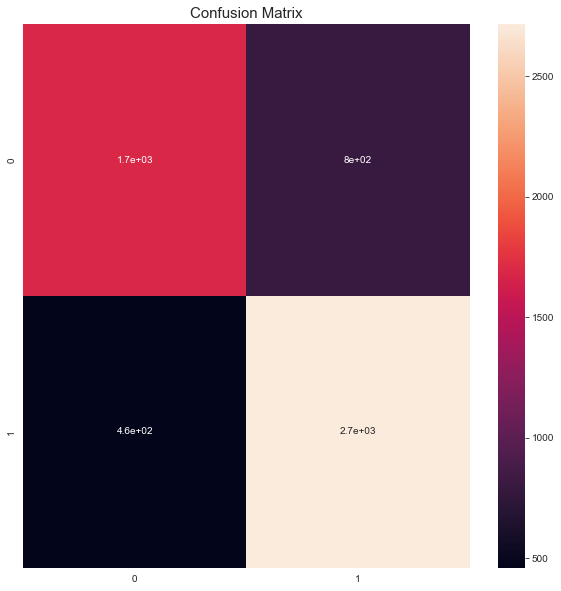

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

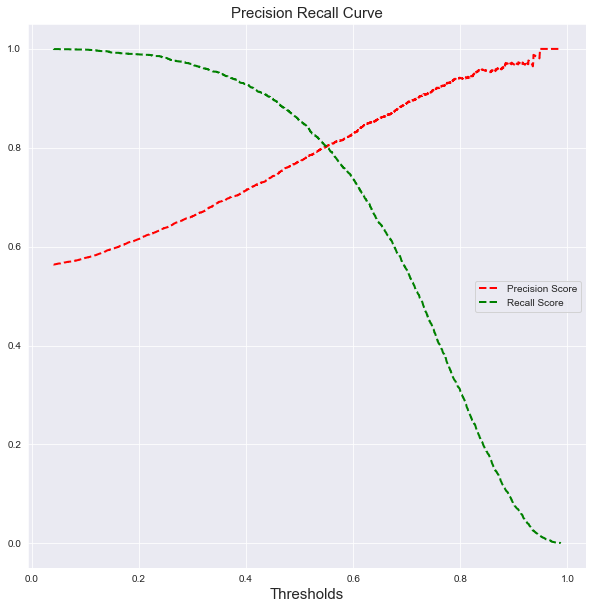

In [53]:
# Evaluating the Logistic Regression Model.
Evaluation_Report(log_clf,X_train,y_train)

The Cell above gives the evaluation Reports and Displays Results for the Logistic Regression Classifier with default parameters.

The Model achieves an Accuracy of 84% when evaluated on the train data on it and an Accuracy of 78 % when evaluated using cross validation. This difference may indicate that the model overfits the train data (84%),We will try to tune this model by regularizing it. 

### Logistic Regression Model Tuning

We will use ``Grid search`` to try out various values of C and select the best performing of them based on cross validation. Grid SearchCV is contained in the sklearn's model_selection module.

In [54]:
## Implementing GridSearchCV
params_dict={'C':[0.01,0.1,1,10]} # Values of C to be evaluated.
grid=GridSearchCV(log_clf,param_grid=params_dict,cv=5) # Implements the Log Clf for diffrent values of C and evaluate using 3 Fold cross validation
grid.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [55]:
# Shows the Best value of C found and the best score Obtained.
grid.best_params_,grid.best_score_

({'C': 1}, 0.778486085597822)

The output sbove shows that the best value of C found coincide with the default value for C which is 1.

In [56]:
# Grid Search Cross Validation report DataFrame
cv_results=pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.137924,0.008855,0.005420,0.002868,0.01,{'C': 0.01},0.560459,0.568021,0.562721,0.566254,0.566254,0.564742,0.002748,4
1,0.204378,0.007141,0.004362,0.004442,0.1,{'C': 0.1},0.733451,0.750000,0.749117,0.749117,0.726148,0.741567,0.009886,3
2,0.342719,0.023398,0.006632,0.004832,1,{'C': 1},0.768756,0.785336,0.780919,0.785336,0.772085,0.778486,0.006862,1
3,0.576586,0.044378,0.004704,0.002517,10,{'C': 10},0.766990,0.772968,0.779152,0.749117,0.767668,0.767179,0.010034,2


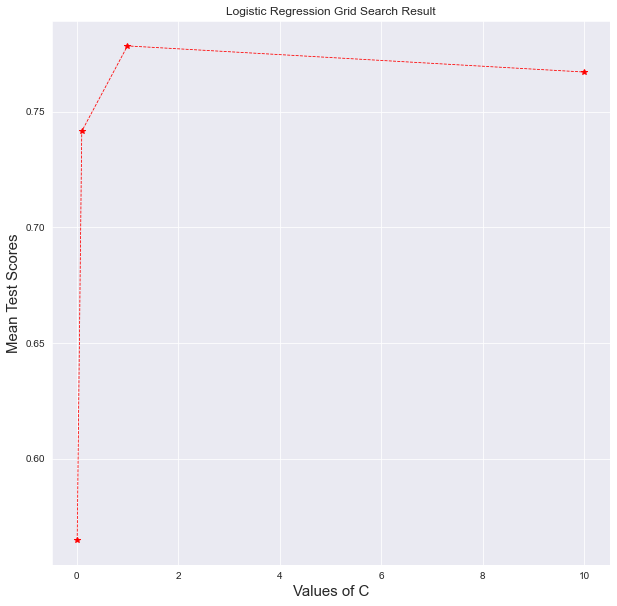

In [57]:
## Ploting the CV results
plt.figure(figsize=(10,10))
plt.title('Logistic Regression Grid Search Result')
plt.ylabel('Mean Test Scores',size=15);plt.xlabel('Values of C',size=15)
plt.plot(cv_results.param_C,cv_results.mean_test_score,'r*--',lw=0.8)

The Tuning above achieved no new results and output same parameter of C as the default value. There fore the results should be same

Accuracy Score: 0.84

Cross Validation Accuracy Score: 0.78

               precision    recall  f1-score   support

           0       0.79      0.68      0.73      2486
           1       0.77      0.86      0.81      3175

    accuracy                           0.78      5661
   macro avg       0.78      0.77      0.77      5661
weighted avg       0.78      0.78      0.78      5661



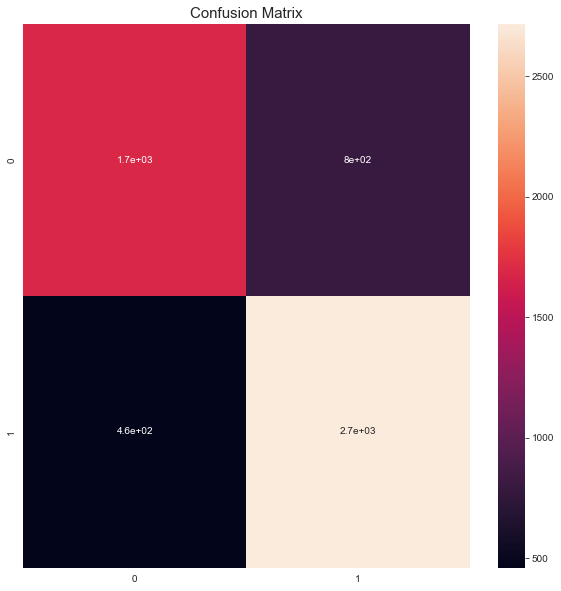

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

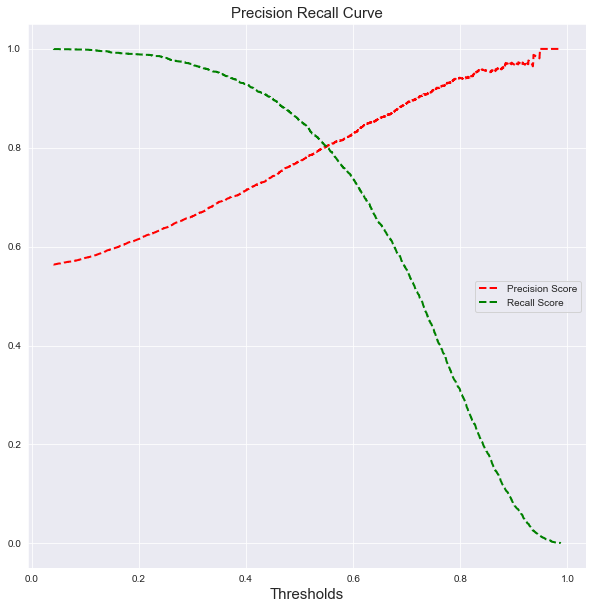

In [58]:
Evaluation_Report(grid.best_estimator_,X_train,y_train)

#### Logistic Regression: Test Evaluation

We will evaluate the Logistic Regression Classifier on the Hold out test data. This data has not not been seen by the model. 

In [59]:
log_pred=log_clf.predict(X_test)
print('Logistic Classifier Test Accuracy Score: {}'.format(round(accuracy_score(y_test,log_pred),2)))
print('\nLogistic Classifier Test Precision Score: {}'.format(round(precision_score(y_test,log_pred),2)))
print('\nLogistic Classifier Test Recall Score: {}'.format(round(recall_score(y_test,log_pred),2)))

Logistic Classifier Test Accuracy Score: 0.76

Logistic Classifier Test Precision Score: 0.76

Logistic Classifier Test Recall Score: 0.86


### GradientBoosting Classifier

In [60]:
# Gradient Boosting Classifier
grad_clf=GradientBoostingClassifier(random_state=42)
grad_clf.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

Accuracy Score: 0.81

Cross Validation Accuracy Score: 0.74

               precision    recall  f1-score   support

           0       0.76      0.61      0.68      2486
           1       0.73      0.85      0.79      3175

    accuracy                           0.74      5661
   macro avg       0.75      0.73      0.73      5661
weighted avg       0.75      0.74      0.74      5661



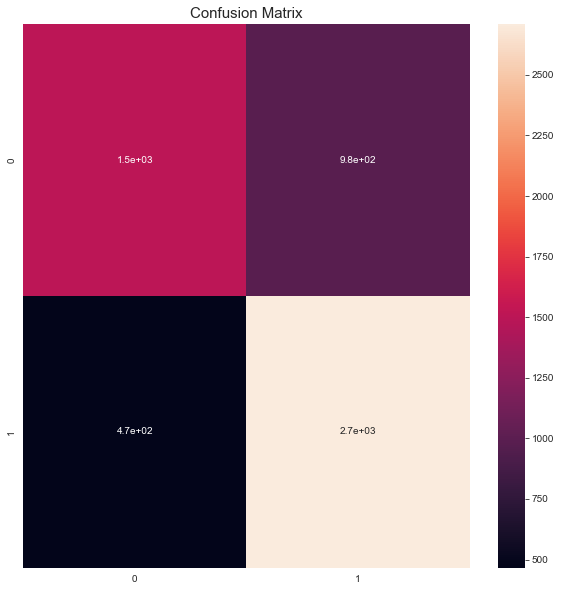

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

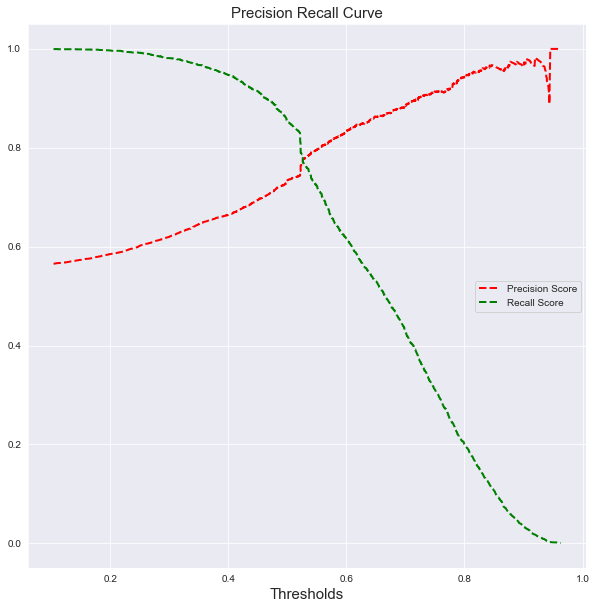

In [61]:
Evaluation_Report(grad_clf,X_train,y_train)

Results for Default GradientBoostingClassifier is shown above. An accuracy score of 0.74 was achieved using cross validation

### Gradient Boosting Tuning

The Gradient Boosting Classifier will be tuned using Grid Search parameters to be tuned include the following:
1. Min_Samples_Split
2. Min_Samples_Leaf
3. Max_Depth
4. Max_Leaf_Nodes

Tuning A ``GradientBoosting`` algorithm of large dimensions and feature space completely is computational costly for this reason, the test data will be used to used to tune the model because it has less data. The parameters gotten will be trained on the train data and finally evaluated using cross validation and Test Data. This is not bounded to give optimum results but it will give a near optimal one.

In [62]:
params_grid={'min_samples_split':[2,3,4],'min_samples_leaf':[5,8],'max_leaf_nodes':[65,75,80],'max_depth':[5]} # Parameters to be ried 
grid=GridSearchCV(grad_clf,param_grid=params_grid,cv=3) # Implements the Grad Clf for diffrent values of the parameters and evaluate using 3 Fold cross validation.
grid.fit(X_test,y_test) # Fits the Grid search on test data

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [5], 'max_leaf_nodes': [65, 75, 80],
                         'min_samples_leaf': [5, 8],
                         'min_samples_split': [2, 3, 4]})

In [63]:
# Show the Best params
grid.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 65,
 'min_samples_leaf': 8,
 'min_samples_split': 2}

In [64]:
# Best Grid Score
grid.best_score_

0.7062146892655368

In [65]:
# Gradient Boosting Classifier
grad_clf=GradientBoostingClassifier(**grid.best_params_) # Uses the best parasms from Grid Search
grad_clf.fit(X_train,y_train) # Fits Tuned parameter Model on train data.

GradientBoostingClassifier(max_depth=5, max_leaf_nodes=65, min_samples_leaf=8)

Accuracy Score: 0.86

Cross Validation Accuracy Score: 0.75

               precision    recall  f1-score   support

           0       0.77      0.63      0.69      2486
           1       0.75      0.85      0.79      3175

    accuracy                           0.75      5661
   macro avg       0.76      0.74      0.74      5661
weighted avg       0.75      0.75      0.75      5661



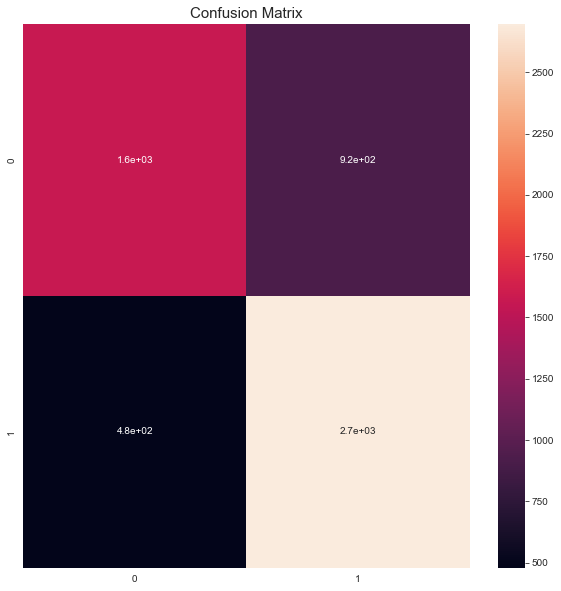

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

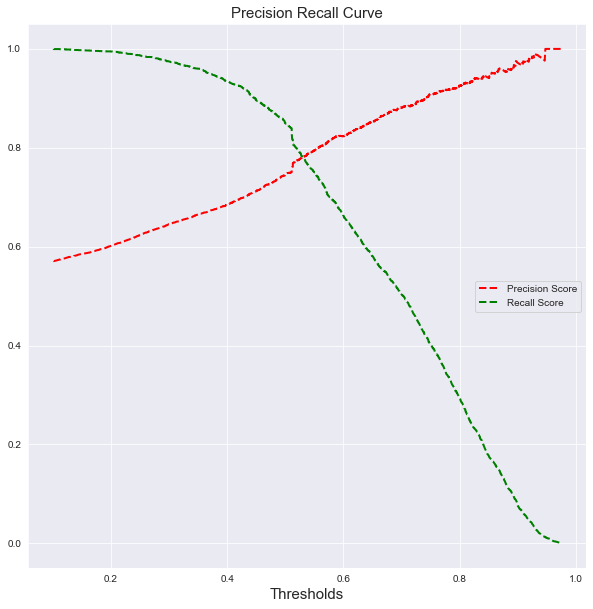

In [66]:
Evaluation_Report(grad_clf,X_train,y_train)

### Gradient Boosting : Test Evaluation

In [67]:
grad_pred=grad_clf.predict(X_test)
print('Gradient Boosting Classifier Test Accuracy Score: {}'.format(round(accuracy_score(y_test,grad_pred),2)))
print('\nGradient Boosting Classifier Test Precision Score: {}'.format(round(precision_score(y_test,grad_pred),2)))
print('\nGradient Boosting Classifier Test Recall Score: {}'.format(round(recall_score(y_test,grad_pred),2)))

Gradient Boosting Classifier Test Accuracy Score: 0.74

Gradient Boosting Classifier Test Precision Score: 0.73

Gradient Boosting Classifier Test Recall Score: 0.85


#### Discussion of Result

The Logistic Regression uses a Non-Linear Function to Transform a Output of Linear Regression to a Non-Linear One Bounded between 0,1 that can best be taken as probability. GradientBoosting is an ensemble method that combines the predictions of numerous individual decision trees.

The Logistic Regression shows better results than GradientBossting . Our discussions will be based on the logistic Regression Model.

For this task,the Logistic Regression was first implemented using it default hyperparameters and the model gotten indicated a likely overfit of the Train data.We then tried to regularize it by trying different Values for the Hyperparameter C. In Logistic Regression The parameter C controls the level of Regularization applied to the model, it can be used in most instance to mitigate the problem of overfit and complexity.

At the end of Data Modelling using Logistic Regression the following ``Observations`` were made and ``results`` obtained:
1. The Model Hyperparameter Tuning Failed to achieve any new result, rather it Gave the same default value for C (C=1). Therefore the result from the tuned parameter and Base model are the same. Logistic is less prone to overfitting.
2. An Accuracy of 84% was gotten when the model was tested on the train data. This is not a true measure of the performance of the model.
3. An Accuracy of 78% was achieved when evaluated using Cross Validation. This is rather a true representation of how the model may likely perform on unseen data.
4. Other Metrics Used were tested using Cross Validation these Includes:
5. Precision Score: 77% (0.77)
6. Recall Score: 86% (0.86)
7. F1 Score: 81% (0.81)

1. An Accuracy score of 0.78 on cross validation implies that 78% of the data points were correctly classified.
2. A Precision score of 0.77 on cross validation for the positive class implies that of all data points classified as Positive (Class 1) 77% was correctly predicted. A Precision of 0.79 on cross validation for the Negative class implies that of all data points classified as Negative (Class 0) 79% was correctly classified.
3. A Recall score of 0.86 on cross validation for the positive class implies 86% of the total positive class (Class 1) in the train set were correctly classified.While A Recall score of 0.68 on cross validation for the negative class implies 68% of the total negative class (Class 0) in the train set were correctly classified.

A Models Performance ``Confusion Matrix`` shows the Number of Classifications Gotten correctly and wrongly.There are  3175 Positive Classes (1) and 2486 Negative classes(0), The Confusion Matrix shows that:
1. Of the 3175 Positive Classes, 2700 were Predicted Correctly as Positives (True Positives,loc: Bottom Right Corner) while 460 were Wrongly Predicted (False Postives,loc: Bottom Left Corner).
2. Of the 2486 Negative Classes, 1700 were predicted Correctly as Negatives (True Negatives, loc: Top Left Corner) While 800 were wrongly classified as Positives (False Negatives, loc: Top Right Corner).


The Precision Recall Curve shows the Values of the precision and Recall at Different Thresholds, While The Recall (Blue) Decreases Steadily From Threshold Zero, The Precision (Red) Increases steadily from Threshold Zero. They Intersect at 0.5 < Threshold < 0.6. at this point of intersection gives the F1_Score as 0.81. The Threshold used at default For decision making occurs at the F1 score this coincides with the point where the Precision and Recall score intersect.

The Precision and Recall score can be varied by changing the threshold for Decision Making depending on the need, from the Precision-Recall plot if the threshold is set at 0.1 or below a Recall score of 1 will be obtained while the Precision will be approximately 0.58. If this threshold is then changed to 1 the Precision Score will be almost perfect i.e almost 1 while Recall score will be 0. This change of threshold depends on what is desired from the model. if we want a model to output the instance of a Positive Star Review with certainty (i.e a probability of almost 1) we will set the Threshold to between 0.98 and 1, any instance classified as positive(1) from this model will be taken with much confidence to be very accurate, the downside of settting the threshold to this value is that, instances of class 1 which are not very explicit,clear to the model and have a confidence value less than 0.98 will be classified as Negative(0). Setting the Threshold at between 0 and 0.1 will achieve a Recall score of >0.98 and a Precision score of approximately 0.58, This will ensure that >0.98 of the Positive instance will be correctly predicted but each of these prediction will have a confidence value of 0.58 that means each classification of Postitve Class have a 58% of being correct. 

## REVIEW HELPFULNESS INFORMATION CLASSIFICATION

### Target Variable Preprocessing

The Target Variable is the Review Help which is the Review helpfulness information. This model has no defined Threshold to distinguish Between helpful and unhelpful Reviews. We will first extract the Digits from the reviews help, then take the percentage of each Helpful review helpfulness as a fraction of the total Review Helpfulness to two decimal place. A threshold will then be set to distinguish between Helpful and Non Helpful Reviews.

In [68]:
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,1,472 out of 477 users found this review helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,1,17 out of 17 users found this review helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,0,1 out of 14 users found this review helpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,0,23 out of 26 users found this review helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,0,4 out of 19 users found this review helpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [69]:
# Extract only the Numbers/Digitsf rom the Review Help Coulmns
data['Reviews Help']=[re.findall(r'\d+',rating) for rating in data['Reviews Help']] # Extracts The Ratings and convert to integer
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,1,"[472, 477]","Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,1,"[17, 17]",There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,0,"[1, 14]",Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,0,"[23, 26]","I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,0,"[4, 19]","If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


The Reviews Help Column in the cell above contains lists of values. The First entry in each List gives the Number of persons who found the review information helpful. while the second entry gives the total number of persons who had an opinion either positive,negative or neutral about the Reviews.

We will take the fraction of the Number of the Persons who found the Review Information helpful of the total number of reviews helpfulness i.e the first_entry/second_entry in each list.

In [70]:
data['Reviews Help']=[round(int(Review[0])/int(Review[1]),2) for Review in data['Reviews Help']] # Divides the first_entry byt the second entry in the list rounded up to two decimal place.
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,1,0.99,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,1,1.00,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,0,0.07,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,0,0.88,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,0,0.21,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


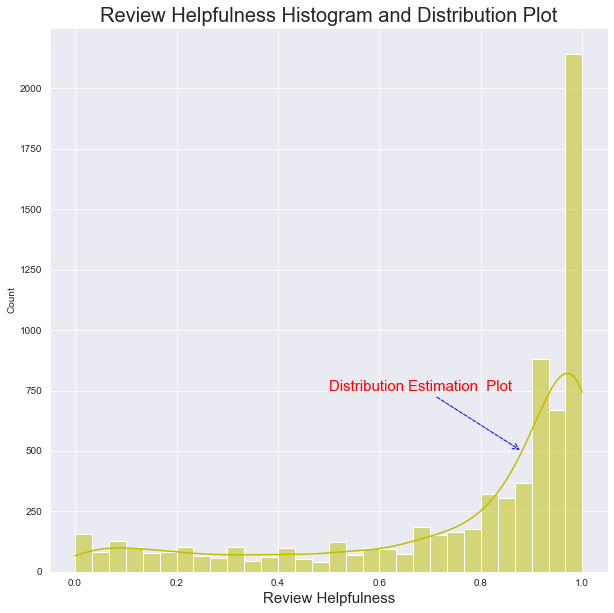

In [71]:
# Plot of Reviews Help
plt.figure(figsize=(10,10))
plt.title('Review Helpfulness Histogram and Distribution Plot',size=20)
plt.xlabel('Review Helpfulness',size=15)
sns.histplot(data['Reviews Help'],kde=True,color='y')
plt.annotate(text='Distribution Estimation  Plot',xy=(0.88,500.0),xytext=(0.5,750.0),size=15,color='r',arrowprops={'arrowstyle':'->','linestyle':'--','color':'b'})
plt.show()
plt.close()

The plot above shows the Histogram of the Review Helpfulness information and the Kernel Density Estimation (KDE) plot. This shows that much of the Values abound in the region above 0.8. For the sake task we seek to set a threshold to differentiate between 'Helpful' and 'Unhelpful' Reviews.

We will set the thresholds at 0.50 (50%). This means that reviews that less than 50% of people do not finf helpful will be given a score of ``0`` while those with above 50% of positive Review Helpfulness information will be set to ``1`` indicating that the reviews is considered helpful 

<AxesSubplot:title={'center':'Review HelpFulness Class Plot'}, xlabel='Review HelpFulness', ylabel='Count'>

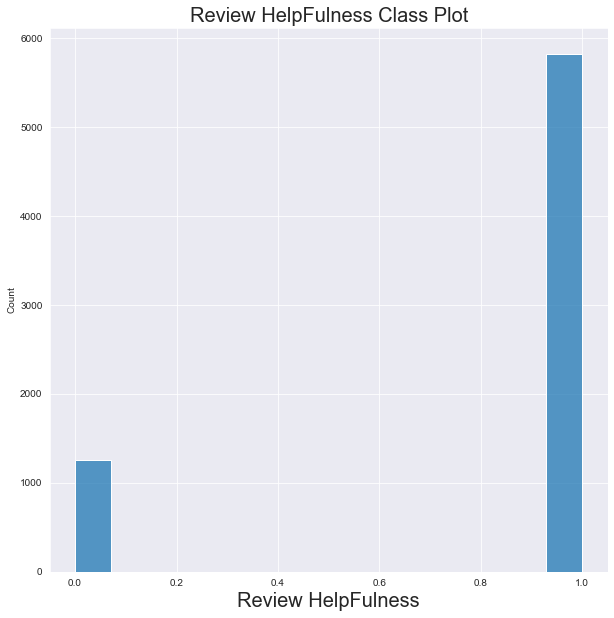

In [72]:
# Setting Threshold and Display Results
y_target=np.where(data['Reviews Help']>=0.50,1,0) # Creates the Target Variable with Review Fraction<=0.5 as 0 and Reviews Fraction > 0.5 as 1 
data['Reviews Help']=np.where(data['Reviews Help']>=0.50,'helpful','unhelpful')
plt.figure(figsize=(10,10))
plt.title('Review HelpFulness Class Plot',size=20)
plt.xlabel('Review HelpFulness',size=20)
sns.histplot(y_target)

The Reviews helpfulness have been categorized as either Helpful or Unhelpful as seen in the cell Above.

The Plot above shows that the classes are highly inbalanced  that means there are almost 3 times or class 1 than class 0. This can pose a challenge for our model. 

In [73]:
data.head(5)

,Titles,Star_Ratings,Reviews Help,Reviews,Titles_Reviews
0,This filter works PERFECT!,1,helpful,"Seriously, I love my Keurig. I love the conven...","This filter works PERFECT! Seriously, I love m..."
1,This stuff is great for muffins,1,helpful,There's a recipe on the back of the package fo...,This stuff is great for muffins There's a reci...
2,Curiously awful,0,unhelpful,Cola is by far my favorite drink. My wife and ...,Curiously awful Cola is by far my favorite dri...
3,Rancid!,0,helpful,"I love chia, but I have gotten two different p...","Rancid! I love chia, but I have gotten two dif..."
4,They taste like boogers,0,unhelpful,"If you don't like the sound of a salty, vinega...",They taste like boogers If you don't like the ...


In [74]:
# Show Target Variable
y_target[:5]

array([1, 1, 0, 1, 0])

### Data Modelling and Machine Learning


We will split our dataset into train and test. The test data will comprise 20% of the total entry while train will be 80%. The test data is ot part of the training Set,it will be used to finally evaluate the Performance of the model.

In [75]:
X_train,X_test,y_train,y_test=train_test_split(data_mat,y_target,test_size=0.20,random_state=42)
X_train.shape,X_test.shape

((5661, 1000), (1416, 1000))

### Logistic Regression

In [76]:
# Logistic Regression without Model Tuning and Class weights
log_clf=LogisticRegression(random_state=42,max_iter=1000) # Logistic Regression with max iterartion increased to 1000
log_clf

LogisticRegression(max_iter=1000, random_state=42)

Accuracy Score: 0.84

Cross Validation Accuracy Score: 0.83

               precision    recall  f1-score   support

           0       0.70      0.04      0.08       987
           1       0.83      1.00      0.91      4674

    accuracy                           0.83      5661
   macro avg       0.77      0.52      0.49      5661
weighted avg       0.81      0.83      0.76      5661



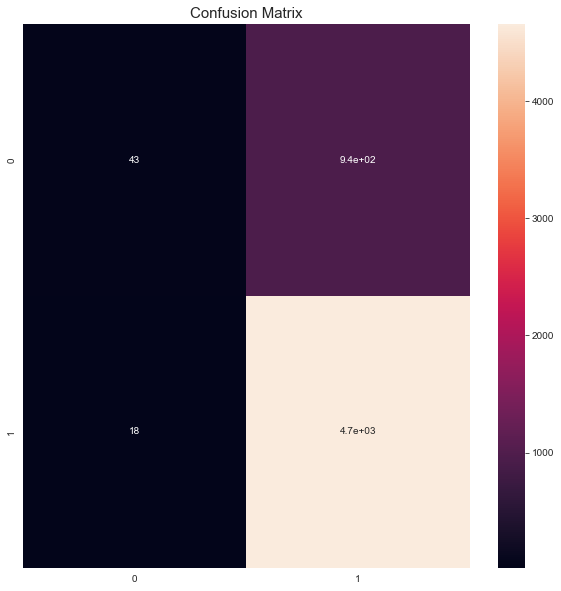

array([1, 1, 1, ..., 1, 1, 1])

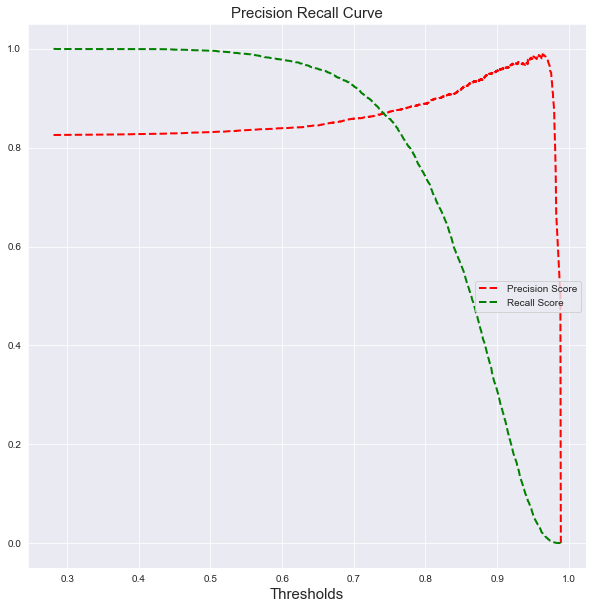

In [77]:
# Evaluating the Logistic Regression Model.
Evaluation_Report(log_clf,X_train,y_train)

The Cell above gives the Evaluation Report and Displays Results for the Logistic Regression Classifier.

The results of the Logistic regression shown above looks promising and high but a closer look shows that the ``Recall`` for Class 1 which is the majority class is 0.99(perfect) while the ``Recall`` for class 0 is 0.06(poor) This indicates that almost all instances of class 1(Helpful Reviews) were rightly classified(99%) as 1, while almost all the instances of class 0(Unhelpful Reviews) were wrongly classified together as class 1. This occurs because there are much more samples of class 1 than class 0 therefore since the model encounters instances of class 1 more often it will then likely classify every instance it may meet as class 1.This phenomenom if not handled will be extended to unseen test data. 

The Confusion Matrix shows that only 62 of the 1000+ instances of class 0(Unhelpful reviews) were rightly classified  as Unhelpful while the rest were Wrongly classified as Helpful. On the other hand 4600+ of Helpful Reviews were correctly classified as Helpful while 29 only were classified wrongly.This means the model perfroms very well on he Helpful Class and poorly on the Unhelpful Class.


This model will mostly classify unseen data as Helpful because of this imbalance.

Imbalance dataset problem in Machine Learning can be handled in a number of ways namely:
1. Getting more Data 
2. Generating Synthetic Data e.g using KNN
3. Using Class weight

We will employ the last option to solve this problem of Imbalance for this task. Class weights implies assigning weights to each class of the model, this gives the model a clue on the class to pay closer attention to. we will assign a higher weight to the minority class(0) and lesser weight to the majority class. This makes the model to pay closer attention to instances of the minority class.

In [78]:
# Logistic Regression with class weights
log_clf=LogisticRegression(random_state=42,max_iter=1000,class_weight={0:4,1:1}) # Logistic Regression with max iterartion increased to 1000
log_clf

LogisticRegression(class_weight={0: 4, 1: 1}, max_iter=1000, random_state=42)

The Class weight parameter is part of the Logistic Regression Algorithm in sklearn. We pass this parameter to the classifier with class 0(Unhelpful Reviews) having a class weights of 4 while class 1(Helpful Reviews) have a class weight of 1.

Accuracy Score: 0.82

Cross Validation Accuracy Score: 0.75

               precision    recall  f1-score   support

           0       0.34      0.50      0.41       987
           1       0.88      0.80      0.84      4674

    accuracy                           0.75      5661
   macro avg       0.61      0.65      0.62      5661
weighted avg       0.79      0.75      0.76      5661



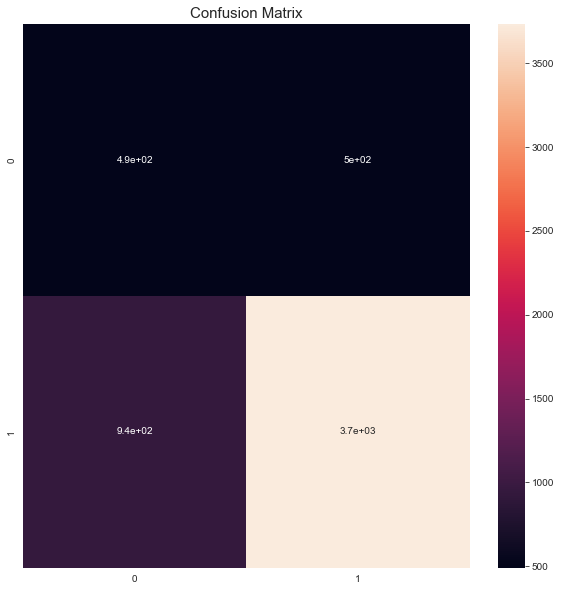

array([1, 0, 1, ..., 1, 1, 1])

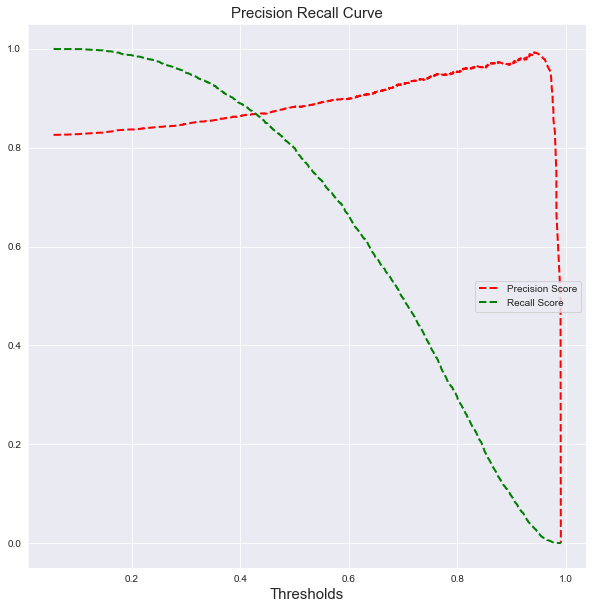

In [79]:
# Evaluating the Logistic Regression Model.
Evaluation_Report(log_clf,X_train,y_train)

The Results above shows improved result for class 0 (unhelpful Reviews), its Recall has improved to 0.5 and precision to 0.34. The Confusion Matrix also shows improved performance of the model on class 0. 490 was able to  be correctly  classified against the 49 earlier with the equal class weights. while the model performance on class 1 decreased 

These scores can be adjusted based on need and objectives. for this task we will be satisfied with these weights and its results.

#### Logistic Regression: Test Evaluation

We will evaluate the Logistic Regression Classifier on the Hold out test data. This data has not not been seen by the model. 

In [80]:
log_pred=log_clf.predict(X_test)
print('Logistic Classifier Test Accuracy Score: {}'.format(round(accuracy_score(y_test,log_pred),2)))
print('\nLogistic Classifier Test Precision Score: {}'.format(round(precision_score(y_test,log_pred),2)))
print('\nLogistic Classifier Test Recall Score: {}'.format(round(recall_score(y_test,log_pred),2)))

Logistic Classifier Test Accuracy Score: 0.74

Logistic Classifier Test Precision Score: 0.88

Logistic Classifier Test Recall Score: 0.79


### GradientBoosting Classifier

In [81]:
# Gradient Boosting Classifier
grad_clf=GradientBoostingClassifier(random_state=42)
grad_clf.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

Accuracy Score: 0.84

Cross Validation Accuracy Score: 0.83

               precision    recall  f1-score   support

           0       0.52      0.05      0.09       987
           1       0.83      0.99      0.90      4674

    accuracy                           0.83      5661
   macro avg       0.68      0.52      0.50      5661
weighted avg       0.78      0.83      0.76      5661



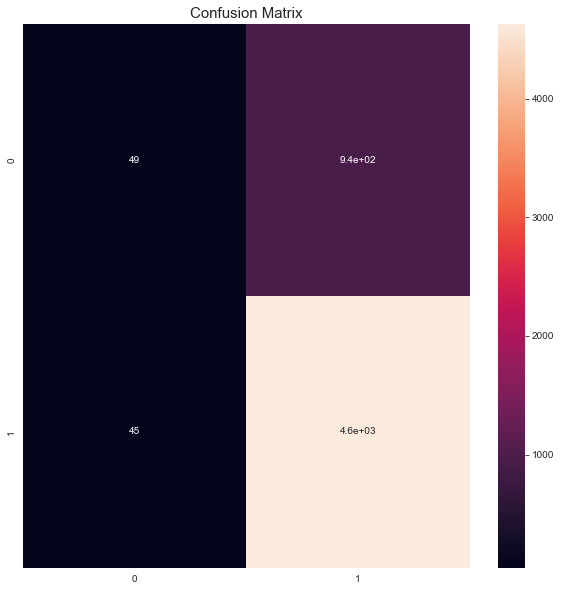

array([1, 1, 1, ..., 1, 1, 1])

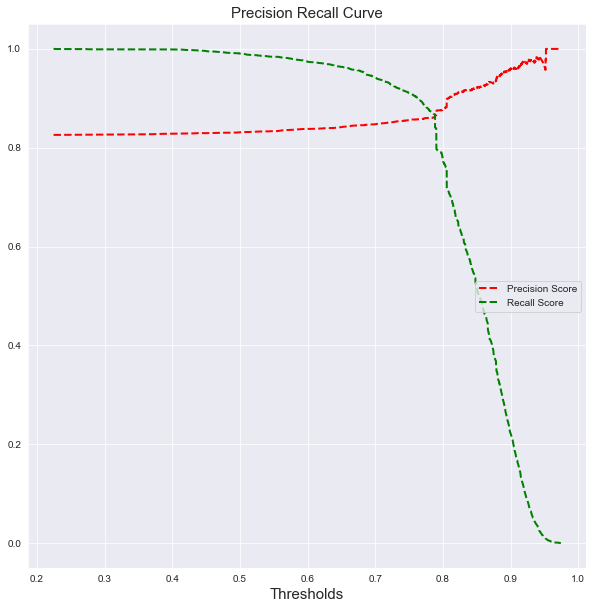

In [82]:
Evaluation_Report(grad_clf,X_train,y_train)

The  Default GradientBoostingClassifier has same problem of class imbalance as the Logistic Regression as shown in the result. The GBC does not support Class weights therefore we will employ a different approach to solve the problem of imbalance.

### Gradient Boosting Tuning

Tuning the model will most likely search for the best parameters that will yield better performance on the model. This may mean improve performance on the majority class and non-performance on the minority class, for this reason we will define a ``Scorer`` that will used in the grid search, this scorer tries to get the parameters that maximizes the performance of the model on the minority class.

In [91]:
# Defining Scorer to calculate f1_score of the minority class
f1_min_scorer=make_scorer(f1_score,average='binary',pos_label=0) # Make Scorer is an Sklearn Function used to make custome scorers
f1_min_scorer

make_scorer(f1_score, average=binary, pos_label=0)

In [92]:
params_grid={'min_samples_split':[2,5],'min_samples_leaf':[5,8,10],'max_leaf_nodes':[50,75],'max_depth':[5,10]} # Parameters to be tried 
grid=GridSearchCV(grad_clf,param_grid=params_grid,cv=3,scoring=f1_min_scorer) # Implements the Grad Clf for diffrent values of the parameters and evaluate using 3 Fold cross validation.
grid.fit(X_test,y_test) # Fits the Grid search on test data

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'max_leaf_nodes': [50, 75],
                         'min_samples_leaf': [5, 8, 10],
                         'min_samples_split': [2, 5]},
             scoring=make_scorer(f1_score, average=binary, pos_label=0))

In [93]:
# Show the Best params
grid.best_params_,grid.best_score_

({'max_depth': 10,
  'max_leaf_nodes': 50,
  'min_samples_leaf': 8,
  'min_samples_split': 2},
 0.19326656101036907)

In [94]:
# Gradient Boosting Classifier
grad_clf=GradientBoostingClassifier(**grid.best_params_) # Uses the best params from Grid Search
grad_clf.fit(X_train,y_train) # Fits Tuned parameter Model on train data.

GradientBoostingClassifier(max_depth=10, max_leaf_nodes=50, min_samples_leaf=8)

Accuracy Score: 0.89

Cross Validation Accuracy Score: 0.83

               precision    recall  f1-score   support

           0       0.51      0.13      0.21       987
           1       0.84      0.97      0.90      4674

    accuracy                           0.83      5661
   macro avg       0.68      0.55      0.56      5661
weighted avg       0.78      0.83      0.78      5661



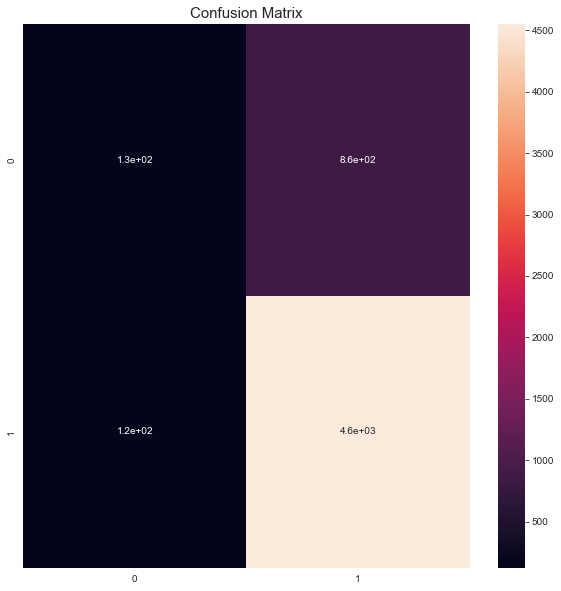

array([1, 0, 1, ..., 1, 1, 1])

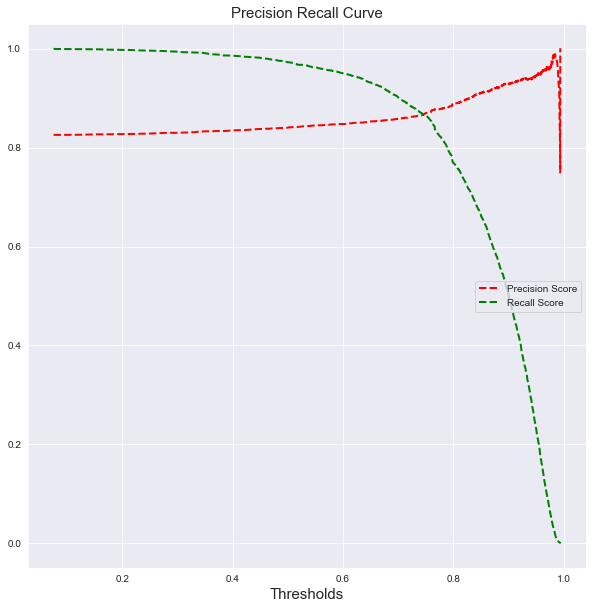

In [95]:
Evaluation_Report(grad_clf,X_train,y_train)

### Gradient Boosting : Test Evaluation

In [96]:
grad_pred=grad_clf.predict(X_test)
print('Logistic Classifier Test Accuracy Score: {}'.format(round(accuracy_score(y_test,grad_pred),2)))

Logistic Classifier Test Accuracy Score: 0.81


#### Discussion of Result

For this task,the Logistic Regression was first implemented using the default hyperparameters and the model gotten indicated an overfit of the Majority Class (Helpful Reviews) of the Train data.We then Applied class weights by assigning a weight of 4 to the minority class 0 (Unhelpful Reviews) and a class weight of 1 to the majority class 1 (Helpful Reviews) to attempt to solve this problem of imbalance. 

The GradientBoosting algorithm had bias towards the majority class ( Helpful Reviews) This caused it to overfit and memorise this class. For the GradientBoosting Algorithm this problem of class imbalance was handled by Tuning the Algorithm to optimise the f1 score for the minority class (Unhelpful reviews) this was done by defining a custom scorer, The Tuned model performed better on the minority class. 

The Logistic Regression Algorithm produced better results on both classes for this task. For this reason the results will be outlined below.

At the end of Data Modelling using Logistic Regression the following ``Observations`` were made and ``results`` obtained:

1. An Overall Accuracy of 0.82 was gotten when the model was tested on the train data. This is not a true measure of the performance of the model.
3. An overall Accuracy of 0.75 was achieved when evaluated using Cross Validation. This is rather a true representation of how the model may likely perform on unseen data.
4. Other Metrics Used were tested using Cross Validation these Includes:
5. Precision Score
    1. Majority Class(Class 1): 88% (0.77)
    2. Minority Class (Class 0) : 34% (0.34)
6. Recall Score 
    1. Majority Class (Class 1): 86% (0.86)
    2. Minority Class (Class 0) : 50% (0.50)
7. F1 Score
    1. Majority Class (Class 1): 84% (0.84)
    2. Minority Class (Class 0): 41% (0.84)

A Models Performance ``Confusion Matrix`` shows the Number of Classifications Gotten correctly and wrongly.There are  5823 Helpful Reviews Classes (1) and 1254 Unhelpful Reviews classes(0), The Confusion Matrix shows that:
1. Of the 5823 Helpful Classes, 4500 were Predicted Correctly as Positives (True Positives,loc: Bottom Right Corner) while 130 were Wrongly Predicted (False Postives,loc: Bottom Left Corner).
2. Of the 1254 Negative Classes, 130 were predicted Correctly as Unhelpful Reviews (True Negatives, loc: Top Left Corner) While 860 were wrongly classified as Helpful Reviews (False Negatives, loc: Top Right Corner).


The Model Results still shows a bias towards the Helpful Review Class (Class 1) which is the majority class with less severity compared with the earlier models with default parameters. The Performance on the minority class (Unhelpful Review) can be improved by adjusting certain parameters such as increasing its class weights for the Logistic Regression but his will come at the detriment of its performance on the majority class. For the gradient Boosting Classifier This can be improved by epanding the grid search space for hyperparameter tuning to find the best hyperparameters that yields the best F1_score for the minority class. Adjusting the model depends on its need and expectation, if exact prediction of the minority class is desired then the earlier recommendations will be implemented .

#### Comparison of Review Sentiment and Review Helpfulness Classification 

To make a logical comparison between the two different classification implemented, the threshold for the Review Helpfulness classification was set to 0.5, Review Helpfulness below 0.5 were set to unhelpful while those above 0.5 was set to helpful. This was done to correspond to the threshold for the review sentiment which specifies that any stars ratings below from 1-2 (Inclusive) were negative while those between 3-4 (Inclusive) were positive.

1. Review Helpfulness had class imbalance with a ratio ``0.79:0.21`` with the helpful class having the majority. Review Sentiment classifiction based on star-ratings had closely equal ``class ratio``. This signifies that Some reviews that had lower star-ratings were still considered helpful thereby having a higher Review Helpfulness Number.

The Results for the two classifiers shown above shows that although Review Helpfulness Classification has higher f1_score overall for class 1 it performs relatively poorer on class 0 which is its minority class unlike the Review sentiment classification that performs well on both of its classes. This is because the Review Helpfulness classification is bias towards the Majority class bacause of class imbalance. It becomes clearer if the precision scores are compared 

The Precision Results shown above shows that Review Sentiment Classifiction serves a reliable way to achieve good results on both classes without the problem of bias. Therefore we can suggest that Review Sentiments provides a Reliable way of classifying the reviews when compared with the Review Helpfulness information.

#### Notes

1. Only the top 1000 words from the text was selected to be used to be used for model building this was done to (i) Reduce the complexity of the model. (ii) To reduce the feature space and make the model trainable, most machine learning models begin to fail when the feature space becomes too large (iii) To prevent overfitting of the model, using much models have the advantage of exposing the model to more information but also have the disadvantage of exposing the model to words that are more specific to a particuar data points, this can cause the model to memorise these features and fail to perform well when exposed to unseen data.
2. Tf-idf( Term Frequency-Inverse Document Frequency) was used for data vectorization.